In [1]:
!nvidia-smi


/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Fri Feb 24 12:33:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+--------------

In [2]:
!pip install transformers
!pip install sentencepiece

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
import urllib.request
import zipfile
url = 'https://gitlab.com/shimorina/webnlg-dataset/-/archive/master/webnlg-dataset-master.zip?path=release_v3.0/en/train'
urllib.request.urlretrieve(url, 'web.zip')
with zipfile.ZipFile('web.zip', 'r') as zip_ref:
    zip_ref.extractall('web')
import glob
import os
import re
import xml.etree.ElementTree as ET
import pandas as pd
files = glob.glob("/kaggle/working/web/webnlg-dataset-master-release_v3.0-en-train/release_v3.0/en/train/**/*.xml", recursive=True)
triple_re=re.compile('(\d)triples')
data_dct={}
for file in files:
    tree = ET.parse(file)
    root = tree.getroot()
    triples_num=int(triple_re.findall(file)[0])
    for sub_root in root:
        for ss_root in sub_root:
            strutured_master=[]
            unstructured=[]
            for entry in ss_root:
                unstructured.append(entry.text)
                strutured=[triple.text for triple in entry]
                strutured_master.extend(strutured)
            unstructured=[i for i in unstructured if i.replace('\n','').strip()!='' ]
            strutured_master=strutured_master[-triples_num:]
            strutured_master_str=(' && ').join(strutured_master)
            data_dct[strutured_master_str]=unstructured
mdata_dct={"prefix":[], "input_text":[], "target_text":[]}
for st,unst in data_dct.items():
    for i in unst:
        mdata_dct['prefix'].append('webNLG')
        mdata_dct['input_text'].append(st)
        mdata_dct['target_text'].append(i)


df=pd.DataFrame(mdata_dct)
df.to_csv('webNLG2020_train.csv')

In [5]:
train_df=pd.read_csv('webNLG2020_train.csv', index_col=[0])
train_df

,prefix,input_text,target_text
0,webNLG,"Alan_Bean | almaMater | ""UT Austin, B.S. 1955""",The alma mater of Alan Bean is UT Austin. He g...
1,webNLG,"Alan_Bean | almaMater | ""UT Austin, B.S. 1955""",Alan Bean graduated in 1955 from UT Austin wit...
2,webNLG,"Alan_Bean | almaMater | ""UT Austin, B.S. 1955""",Alan Bean graduated from UT Austin in 1955 wit...
3,webNLG,"Alan_Bean | almaMater | ""UT Austin, B.S. 1955""",Alan Bean graduated from UT Austin in 1955 wit...
4,webNLG,"Alan_Bean | almaMater | ""UT Austin, B.S. 1955""",Alan Bean received a Bachelor of Science degre...
...,...,...,...
35191,webNLG,Trane | product | Building_Management_System &...,Trane is a subsidiary company founded in Sword...
35192,webNLG,Trane | product | Building_Management_System &...,"Trane, a manufacturer of building management s..."
35193,webNLG,Trane | product | Building_Management_System &...,Trane is a producer of building management sys...
35194,webNLG,Trane | product | Building_Management_System &...,"Located in Swords, Dublin, Trane is a subsidia..."


In [6]:
train_df=train_df.iloc[  :35000,:]

In [7]:
train_df=train_df.sample(frac = 1)

In [8]:
batch_size=8
num_of_batches=len(train_df)/batch_size
num_of_epochs=4

In [9]:
num_of_batches=int(num_of_batches)

In [10]:
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [11]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [12]:

optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [13]:

from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [14]:
num_of_epochs=1

In [15]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'WebNLG: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'   
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
    
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  

Running epoch: 1


Epoch: 1 , Running loss: 0.49903329345498765


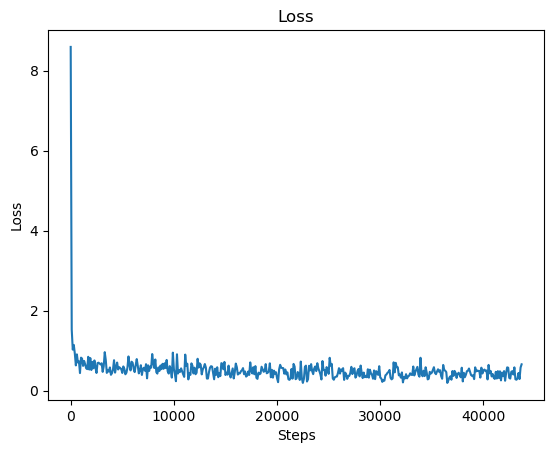

In [16]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [17]:
torch.save(model.state_dict(),'pytorch_model.bin')

In [18]:
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-02-24 13:04:04--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.49.6, 54.231.194.0, 54.231.234.56, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.49.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1199 (1.2K) [application/json]
Saving to: ‘t5-base-config.json’

t5-base-config.json 100%[===================>]   1.17K  --.-KB/s    in 0s      

2023-02-24 13:04:04 (51.6 MB/s) - ‘t5-base-config.json’ saved [1199/1199]



**Loading Saved Model**

In [19]:
model = T5ForConditionalGeneration.from_pretrained('/kaggle/working/pytorch_model.bin', return_dict=True,config='/kaggle/working/t5-base-config.json')

**Creating a function for generating the output**

In [20]:
def generate(text):
  model.eval()
  input_ids = tokenizer.encode("WebNLG:{} ".format(text), return_tensors="pt")  # Batch size 1
  outputs = model.generate(input_ids)
  gen_text=tokenizer.decode(outputs[0]).replace('','').replace('','')
  gen_text = gen_text.replace('<pad>', '').replace('</s>', '').strip()

  return gen_text

In [21]:
generate(' Russia | leader | Putin')

'The leader of Russia is Putin and the leader is Putin.'

In [22]:
generate('Sidharth | profession | Doctor  && Sidharth | home_town |  Bombay ')

'Doctor Sidharth, who was born in Bombay, is a doctor.'

In [23]:
generate('Facebook | CEO | Mark  && Facebook | Number Of Employees | 52000 ')

'Mark is the CEO of the company, which employs 52000 people.'

In [24]:
generate('Aarhus_Airport | cityServed | "Aarhus, Denmark"')

'Aarhus Airport serves the city of Aarhus, Denmark.'